In [2]:
import xlrd
import pandas as pd
import os
import torch
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
import torchvision.utils as vutils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\Alext\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
workbook = xlrd.open_workbook("Metadaten_A_Discriminator.xlsx")
worksheet = workbook.sheet_by_index(0)

In [5]:
data = {
    "ID": [],
    "feature1": [], # Klassisch 1/ Modern 0
    "feature2": [], # Seriös 1/ Verspielt 0
    "feature3": [] # Dominant 1/ Unaufdringlich 0
}

for row_idx in range(3, worksheet.nrows):
    data["ID"].append(worksheet.cell(row_idx, 0).value.replace(".svg", "")+".png")
    data["feature1"].append(worksheet.cell(row_idx, 2).value)
    data["feature2"].append(worksheet.cell(row_idx, 3).value)
    data["feature3"].append(worksheet.cell(row_idx, 4).value)


In [6]:
df = pd.DataFrame(data)
print(df.shape)
df.head()

(140, 4)


,ID,feature1,feature2,feature3
0,A_ACaslonPro-Regular.otf.png,1.0,1.0,0.0
1,A_AdobeArabic-Regular.otf.png,1.0,1.0,0.0
2,A_AdobeDevanagari-Regular.otf.png,1.0,1.0,0.0
3,A_AdobeHebrew-Regular.otf.png,1.0,1.0,0.0
4,A_AGaramondPro-Regular.otf.png,1.0,1.0,0.0


In [7]:
df.to_csv("A_1/Fonts.csv", index=False)

In [8]:
class FontDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.fonts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fonts_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.fonts_frame.iloc[idx, 0])

        image = io.imread(img_path)
        font_attributes = self.fonts_frame.iloc[idx, 1:]
        font_attributes = np.array([font_attributes])
        font_attributes = font_attributes.astype("float").reshape(-1, 3)

        if self.transform:
            image = self.transform(image)

        return image, font_attributes


0 torch.Size([1, 120, 120])
1 torch.Size([1, 120, 120])
2 torch.Size([1, 120, 120])
3 torch.Size([1, 120, 120])
4 torch.Size([1, 120, 120])


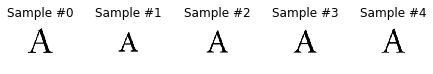

In [9]:
font_dataset = font_dataset = FontDataset(csv_file="A_1/Fonts.csv", 
                            root_dir="A_1/PNG/", 
                            transform=transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Pad(30, 255),
                                transforms.Resize(120),
                                transforms.CenterCrop(120),
                                transforms.ToTensor()
                            ]))

fig = plt.figure()

for i, (image, font_attributes) in enumerate(font_dataset):

    print(i, image.shape)

    # ax = plt.subplot(2, 5, i+1)
    ax = plt.subplot(1, 5, i+1)
    plt.tight_layout()
    ax.set_title(f"Sample #{i}")
    ax.axis("off")

    plt.imshow(image.squeeze(), cmap="gray")

    if i == 4:
        plt.show()
        break


In [10]:
data_loader = torch.utils.data.DataLoader(FontDataset(csv_file="A_1/Fonts.csv", 
                            root_dir="A_1/PNG/", 
                            transform=transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Pad(30, 255),
                                transforms.Resize(160),
                                transforms.CenterCrop(160),
                                transforms.ToTensor()
                            ])),
  batch_size=140, shuffle=True);

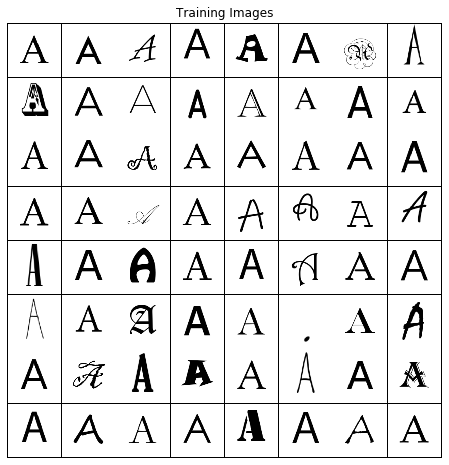

In [11]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

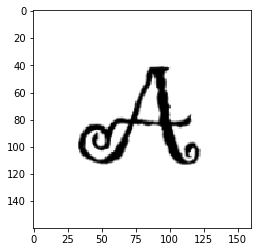

In [39]:
for image, attr in data_loader:
    plt.imshow(image[0].squeeze(), cmap="gray")
    